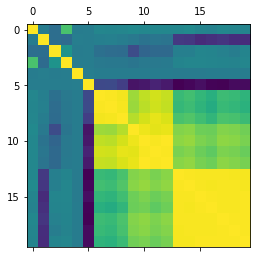

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv("gas_sensor_array.csv")
plt.matshow(dataset.corr())
plt.show()

Estimated number of clusters: 1
Estimated number of noise points: 41
Silhouette Coefficient: 0.504


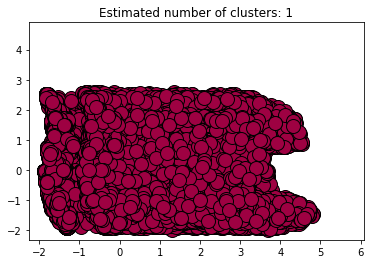

In [16]:
from sklearn import cluster as cl
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def main():

    # Read selected dataset
    dataset = pd.read_csv("datasets/gas_sensor_array.csv")

    # Select relevant columns of dataset
    # subset = dataset
    # subset = dataset[["Time","CO","Humidity","Temperature","Flow rate","Heater voltage"]]
    # subset = dataset[["Time","CO"]]
    # subset = dataset[["Time","Temperature"]]
    # subset = dataset[["Time","Flow rate"]]
    # subset = dataset[["Time","Heater voltage"]]
    subset = corr_df(dataset, 0.45)

    # Reduce rows from 300 000 to specified n
    small_subset = subset.sample(n=80000)

    # Transform data
    scaled_subset = StandardScaler().fit_transform(small_subset)

    # Reduce dimension with PCA
    pca = PCA(n_components=2)
    pca_subset = pca.fit_transform(scaled_subset)

    # Run DBSCAN
    db = cl.DBSCAN(eps=0.5, min_samples=200).fit(pca_subset)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    # Start of results
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pca_subset, labels))
    
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = pca_subset[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = pca_subset[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=0)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x

if __name__ == '__main__':
    main()